In [1]:
import os
import yaml

import math
from natsort import natsorted

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import ListedColormap

from tifffile import imread
from PIL import Image, ImageDraw

import napari

import hdbscan
from umap import UMAP 

from skimage.util import img_as_float
from skimage.color import gray2rgb

In [2]:
def categorical_cmap(numUniqueSamples, numCatagories, cmap='tab10', continuous=False):

    numSubcatagories = math.ceil(numUniqueSamples/numCatagories)

    if numCatagories > plt.get_cmap(cmap).N:
        raise ValueError('Too many categories for colormap.')
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0, 1, numCatagories))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(numCatagories, dtype=int))
        # rearrange hue order to taste
        cd = {
            'B': 0, 'O': 1, 'G': 2, 'R': 3, 'Pu': 4,
            'Br': 5, 'Pi': 6, 'Gr': 7, 'Y': 8, 'Cy': 9,
        }
        myorder = [
            cd['B'], cd['O'], cd['G'], cd['Pu'], cd['Y'],
            cd['R'], cd['Cy'], cd['Br'], cd['Gr'], cd['Pi']
        ]
        ccolors = [ccolors[i] for i in myorder]

        # use Okabe and Ito color-safe palette for first 6 colors
        # ccolors[0] = np.array([0.91, 0.29, 0.235]) #E84A3C
        # ccolors[1] = np.array([0.18, 0.16, 0.15]) #2E2926
        ccolors[0] = np.array([0.0, 0.447, 0.698, 1.0])  # blue
        ccolors[1] = np.array([0.902, 0.624, 0.0, 1.0])  # orange
        ccolors[2] = np.array([0.0, 0.620, 0.451, 1.0])  # bluish green
        ccolors[3] = np.array([0.8, 0.475, 0.655, 1.0])  # reddish purple
        ccolors[4] = np.array([0.941, 0.894, 0.259, 1.0])  # yellow
        ccolors[5] = np.array([0.835, 0.369, 0.0, 1.0])  # vermillion

    cols = np.zeros((numCatagories * numSubcatagories, 3))
    for i, c in enumerate(ccolors):
        chsv = colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv, numSubcatagories).reshape(numSubcatagories, 3)
        arhsv[:, 1] = np.linspace(chsv[1], 0.25, numSubcatagories)
        arhsv[:, 2] = np.linspace(chsv[2], 1, numSubcatagories)
        rgb = colors.hsv_to_rgb(arhsv)
        cols[i * numSubcatagories:(i + 1) * numSubcatagories, :] = rgb
    cmap = colors.ListedColormap(cols)

    # trim colors if necessary
    if len(cmap.colors) > numUniqueSamples:
        trim = len(cmap.colors) - numUniqueSamples
        cmap_colors = cmap.colors[:-trim]
        cmap = colors.ListedColormap(cmap_colors, name='from_list', N=None)

    return cmap

In [3]:
# read and process input data

# out dir
out_dir = '../output/Fig1a,b' 
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# read aggregate csv data
agg = pd.read_parquet('../input/Dataset6(CODEX6)/CODEX6_clean_cylinter_aggregateData.parquet')

# read markers.csv
markers = pd.read_csv('../input/Dataset6(CODEX6)/markers.csv')

# log-transform columns to be used in clustering
clustering_cols = [
    i for i in list(markers['marker_name']) if i in agg.columns
    if 'Hoechst' not in i
]

data = agg[['CellID', 'X_centroid', 'Y_centroid'] + clustering_cols].copy()

log_data = np.log10(data[clustering_cols] + 0.001)
data.update(log_data)

# define image crop window
row_min = 246
row_max = 5290
col_min = 320
col_max = 6000

# select single cells within cropped image
data_crop = data[
    (data['X_centroid'].between(col_min, col_max)) &
    (data['Y_centroid'].between(row_min, row_max))].copy()

# transform x, y coordinates of cells within cropped image
data_crop['X_centroid'] = data_crop['X_centroid'] - col_min
data_crop['Y_centroid'] = data_crop['Y_centroid'] - row_min

# read segmentation outlines and crop
seg = imread('../input/Dataset6(CODEX6)/seg/HBM946.GRVG.379.ome.tif', key=0)
seg_crop = seg[row_min:row_max, col_min:col_max]

# read DNA1 image, crop, and convert to RGB
dna = imread('../input/Dataset6(CODEX6)/tif/HBM946.GRVG.379.ome.tif', key=0)
dna_float = img_as_float(dna)
dna_float -= dna_float.min()
dna_float /= dna_float.max()
dna_crop = dna_float[row_min:row_max, col_min:col_max]
dna_crop_rgb = gray2rgb(dna_crop)

# read SOX9 channel of image, crop, and convert to RGB with colormap
sox9_raw = imread('../input/Dataset6(CODEX6)/tif/HBM946.GRVG.379.ome.tif', key=6)
sox9 = np.clip(sox9_raw, sox9_raw.min(), 9411)  # clipping to preferred intensity
sox9_float = img_as_float(sox9)
sox9_float -= sox9_float.min()
sox9_float /= sox9_float.max()
sox9_crop = sox9_float[row_min:row_max, col_min:col_max].copy()
sox9_crop_rgb = (
    (sox9_crop - np.min(sox9_crop)) / (np.max(sox9_crop) - np.min(sox9_crop))
)  # normalize 0-1

sox9_crop_rgb = plt.cm.magma(sox9_crop_rgb)  # converts to RGBA
sox9_crop_rgb = sox9_crop_rgb[:, :, 0:3]  # drop alpha dimension

dna_crop_rgb /= 1.0  # modify DNA intensity if needed and combine sox9 image with DNA image
dna_crop_rgb += sox9_crop_rgb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


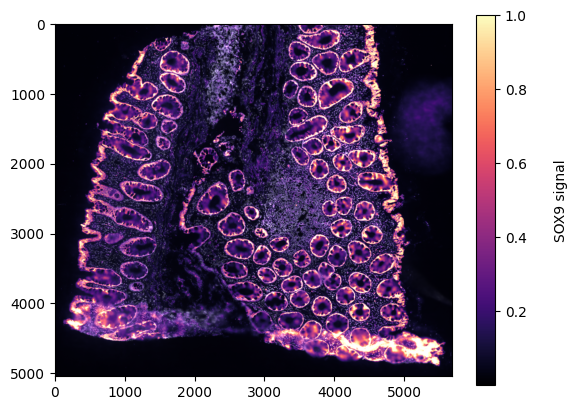

In [4]:
# plot image overlay

plt.imshow(dna_crop_rgb, cmap='magma')
plt.grid(False)
cbar = plt.colorbar()
cbar.set_alpha(1.0)
cbar.set_label('SOX9 signal', labelpad=20, rotation=90)
plt.savefig(os.path.join(out_dir, 'image.png'), dpi=800)
plt.show()
plt.close('all')

In [5]:
# open CODEX image in Napari to select ROIs 
viewer = napari.Viewer()

viewer.add_image(dna_crop, opacity=1.0, rgb=False, name='DNA1')

viewer.add_image(
        seg_crop, rgb=False, blending='additive', opacity=1.0, 
        colormap='green', visible=False, name='segmentation'
    )

viewer.add_image(
    sox9_crop, rgb=False, blending='additive', colormap='magma',
    visible=True, name='SOX9'
)

# read saved polygon vertices (if ROIs have been drawn already) 
if os.path.exists(os.path.join(out_dir, 'rois.yml')):

    polygon_dict = yaml.safe_load(open(os.path.join(out_dir, 'rois.yml')))
        
    shapes = [polygon_dict[i][0] for i in range(0, len(polygon_dict.keys()))]
    polygons = [polygon_dict[i][1] for i in range(0, len(polygon_dict.keys()))]

    selection_layer = viewer.add_shapes(
        data=polygons,
        shape_type=shapes,
        ndim=2,
        face_color=[0.0, 1.0, 0.0, 0.0],  # [1.0, 1.0, 1.0, 0.2]
        edge_color=[0.0, 1.0, 0.0, 1.0], # [0.0, 0.66, 1.0, 1.0]
        edge_width=20.0,
        name='ROI(s)')

else:
    selection_layer = viewer.add_shapes(
        shape_type='polygon', ndim=2, face_color=[1.0, 1.0, 1.0, 0.2],
        edge_color=[0.0, 0.66, 1.0, 1.0], edge_width=10.0, name='ROI(s)'
    )
    
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()
    
# store ROIs
for e, (shape_type, roi) in enumerate(
        zip(selection_layer.shape_type, selection_layer.data)):
    polygon_dict[e] = [shape_type, roi.tolist()]

f = open(os.path.join(out_dir, 'rois.yml'), 'w')
yaml.dump(polygon_dict, f)

In [6]:
# create a dictionary containing cellIDs (values) for each ROI (keys)

roi_data = data_crop[['X_centroid', 'Y_centroid', 'CellID']].astype(int)
roi_data['tuple'] = list(zip(roi_data['X_centroid'], roi_data['Y_centroid']))

cell_ids_dict = {}

for key, value in polygon_dict.items():

    selection_verts = np.round(value[1]).astype(int)

    # create pillow image to convert to boolean mask
    img = Image.new('L', (dna_crop.shape[1], dna_crop.shape[0]))

    vertices = list(tuple(
        zip(selection_verts[:, 1],
            selection_verts[:, 0])
    ))

    # update pillow image with polygon
    ImageDraw.Draw(img).polygon(
        vertices, outline=1, fill=1
    )

    # convert pillow image into boolean numpy array
    mask = np.array(img, dtype=bool)
    
    # use numpy fancy indexing to get centroids
    # where boolean mask is True
    xs, ys = zip(*roi_data['tuple'])
    inter = mask[ys, xs]
 
    cell_ids = set(roi_data['CellID'][inter])
 
    cell_ids_dict[key] = cell_ids

Performing UMAP embedding...


/Users/greg/venvs/cylinter/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


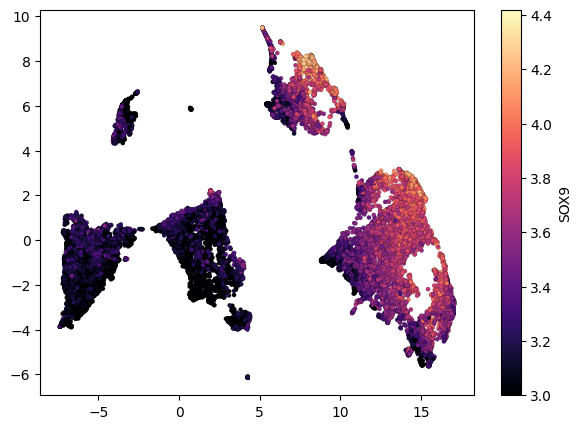

In [7]:
# calculate UMAP coordinates of cropped data and plot

print('Performing UMAP embedding...')
embedding = (
    UMAP(random_state=5, n_neighbors=20, min_dist=0.0005, repulsion_strength=1.5)
    .fit_transform(data_crop[clustering_cols])
)
data_crop['emb1'] = embedding[:, 0]
data_crop['emb2'] = embedding[:, 1]

# plot
fig, ax = plt.subplots(figsize=(7, 5))
lw = 0.1

sc = ax.scatter(
    data_crop['emb1'], data_crop['emb2'], c=data_crop['SOX9'], cmap='magma',
    s=9.5, ec='k', lw=lw, alpha=1.0, vmin=3,
    vmax=data_crop['SOX9'].max()
)

plt.colorbar(sc, label='SOX9')
plt.savefig(os.path.join(out_dir, 'embedding_sox9.png'), dpi=1000)
plt.show()
plt.close('all')

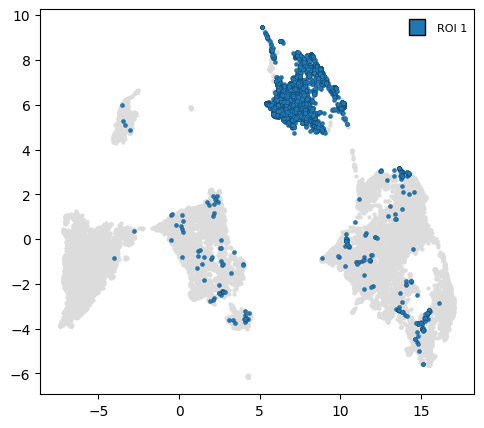

In [8]:
# plot UMAP embedding colored by ROI

# combine cellIDs from each ROI
combo_ids = set()

legend_elements = []
roi_data = {}

for k, v, in cell_ids_dict.items():

    if k == 0:
        name = 'ROI 1'
        roi_data[name] = ('tab:blue', data_crop[data_crop['CellID'].isin(v)])

    combo_ids.update(cell_ids_dict[k])
    
    legend_elements.append(
        Line2D([0], [0], marker='s',
               color='none',
               label=name,
               markerfacecolor=roi_data[name][0],
               markeredgecolor='k',
               lw=0.01, markersize=12)
    )

data_sans_rois = data_crop[~data_crop['CellID'].isin(combo_ids)].copy()

# plot
fig, ax = plt.subplots(figsize=(5.6, 5))
ax.scatter(
    data_sans_rois['emb1'], data_sans_rois['emb2'], c='gainsboro', s=9.5,
    ec='k', lw=0.0, alpha=1.0
)
for k, v in roi_data.items():
    ax.scatter(v[1]['emb1'], v[1]['emb2'], c=v[0], s=9.5, ec='k', lw=lw, alpha=1.0)

ax.legend(
    handles=legend_elements, prop={'size': 8}, loc='upper left',
    bbox_to_anchor=[0.82, 0.99], labelspacing=0.9, frameon=False
)

plt.savefig(os.path.join(out_dir, 'embedding_gate.png'), dpi=1000)
plt.show()
plt.close('all')

Number of cells in cropped image is 22918


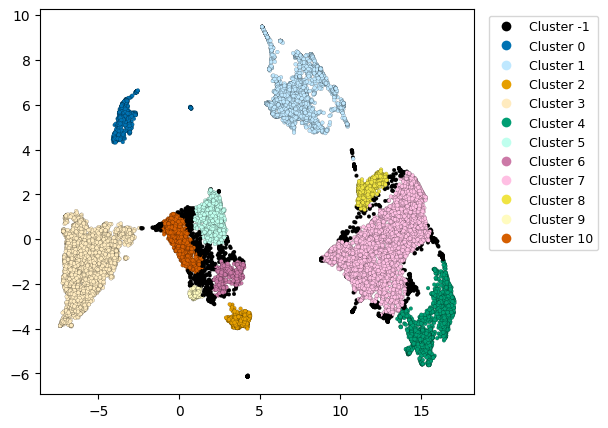

In [9]:
# cluster data with HDBSCAN
clustering = hdbscan.HDBSCAN(min_cluster_size=151).fit(data_crop[['emb1', 'emb2']])
data_crop['cluster'] = clustering.labels_

# generate categorical cmap for clusters
cmap = categorical_cmap(
    numUniqueSamples=len(data_crop['cluster'].unique()),
    numCatagories=10, cmap='tab10', continuous=False
)

cmap = ListedColormap(
    np.insert(arr=cmap.colors, obj=0, values=[0, 0, 0], axis=0)
)

# trim cmap to # unique samples
trim = (
    len(cmap.colors) - len(data_crop['cluster'].unique())
)
cmap = ListedColormap(cmap.colors[:-trim])

sample_dict = dict(
    zip(natsorted(data_crop['cluster'].unique()),
        list(range(len(data_crop['cluster']
             .unique()))
             )
        )
)

c = [sample_dict[i] for i in data_crop['cluster']]

print(f'Number of cells in cropped image is {len(data_crop)}')

fig, ax = plt.subplots(figsize=(5.6, 5))
sc = plt.scatter(
    data_crop['emb1'], data_crop['emb2'], c=c, cmap=cmap,
    s=7.5, ec='k', lw=0.1, alpha=1.0
)

legend_elements = []
for e, i in enumerate(natsorted(data_crop['cluster'].unique())):

    legend_elements.append(
        Line2D([0], [0], marker='o',
               color='none', label=f'Cluster {i}',
               markerfacecolor=cmap.colors[e], markeredgecolor='none',
               lw=0.001, markersize=7)
    )
ax.legend(
    handles=legend_elements, prop={'size': 9}, bbox_to_anchor=(1.3, 1),
    loc='upper right', frameon=True
)
plt.savefig(os.path.join(out_dir, 'clustering.png'), dpi=800)
plt.show()
plt.close('all')

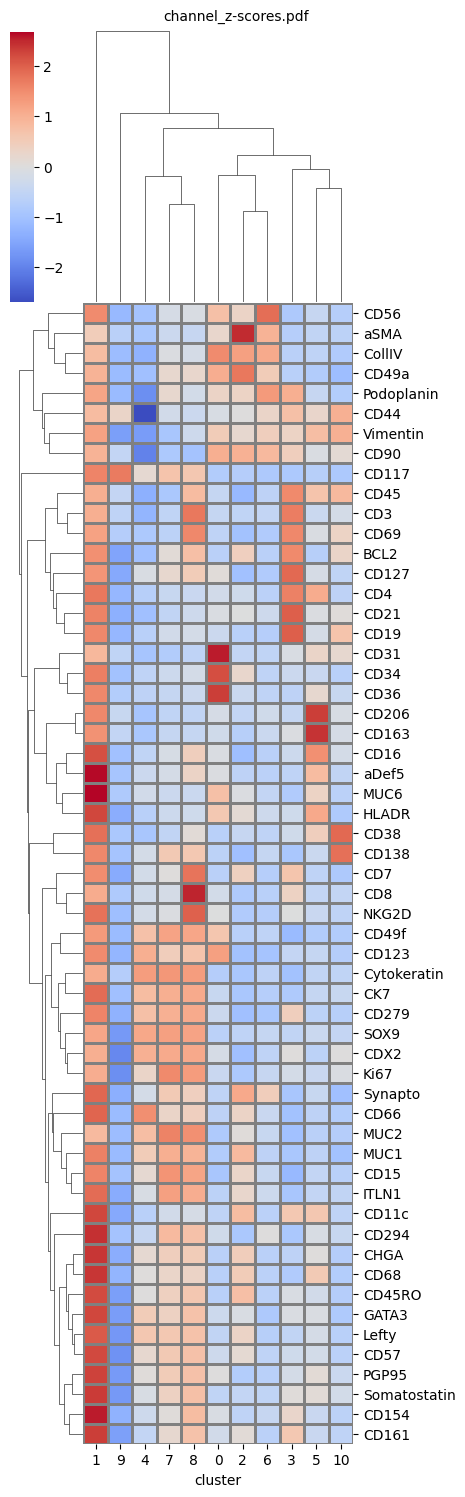

In [10]:
# compute channel means for clustered cell populations 

clustermap_input = data_crop[clustering_cols + ['cluster']].groupby('cluster').mean()
clustermap_input = clustermap_input[clustermap_input.index != -1]

# compute per channel z-scores across gated populations 
clustermap_input = (
    (clustermap_input - clustermap_input.mean()) / clustermap_input.std()
)

# zero-center colorbar
norm = TwoSlopeNorm(
    vcenter=0, vmin=clustermap_input.min().min(),
    vmax=clustermap_input.max().max()
)

g = sns.clustermap(
    clustermap_input.T, cmap='coolwarm', standard_scale=None, square=False,
    xticklabels=1, yticklabels=1, linewidth=1.0, linecolor='grey',
    cbar=True, norm=norm, figsize=(4.7, 15)
)

g.fig.suptitle('channel_z-scores.pdf', y=0.995, fontsize=10)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig(
    os.path.join(out_dir, 'channel_z-scores.pdf'), bbox_inches='tight'
)
plt.show()
plt.close('all')